
100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


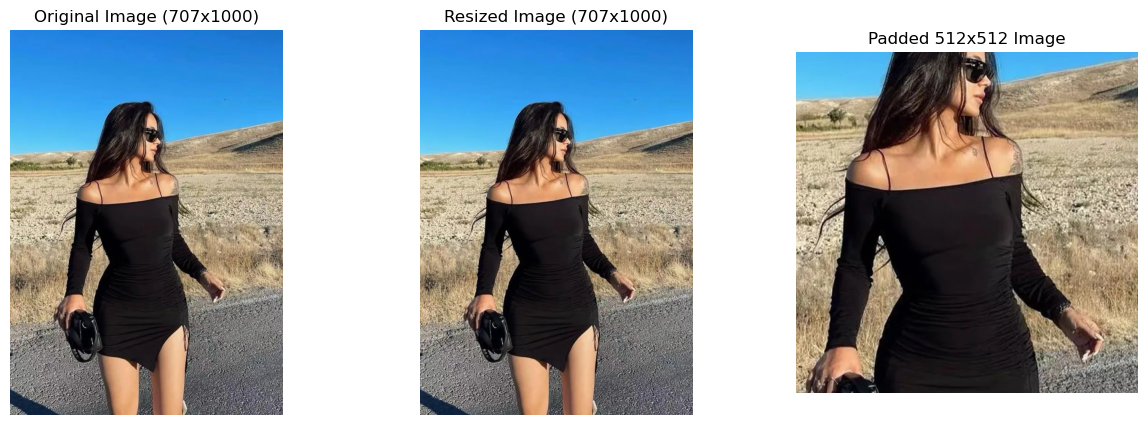

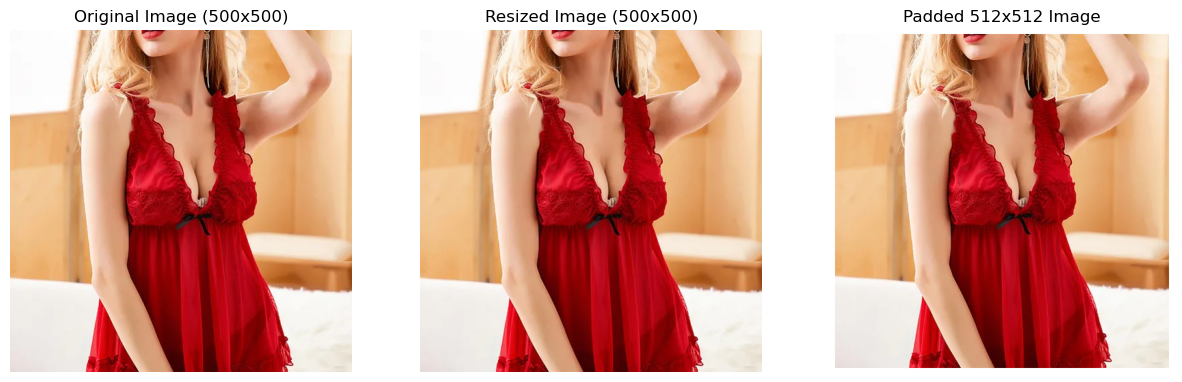

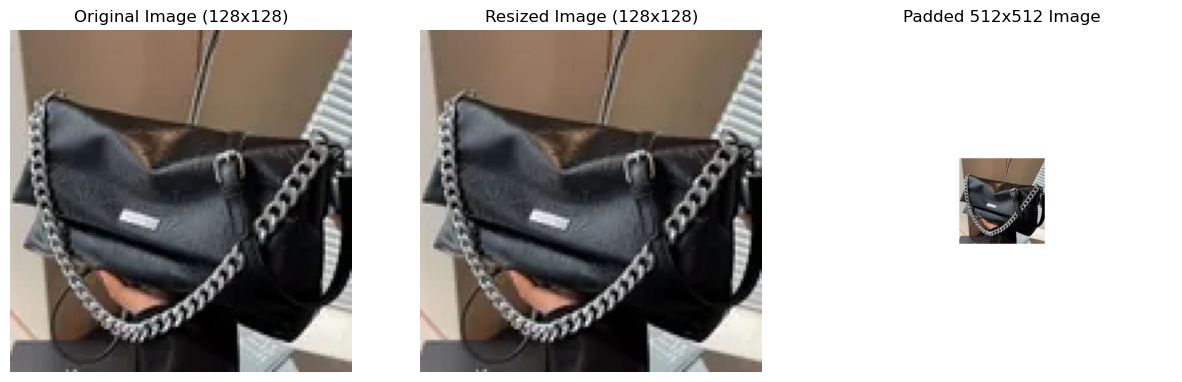

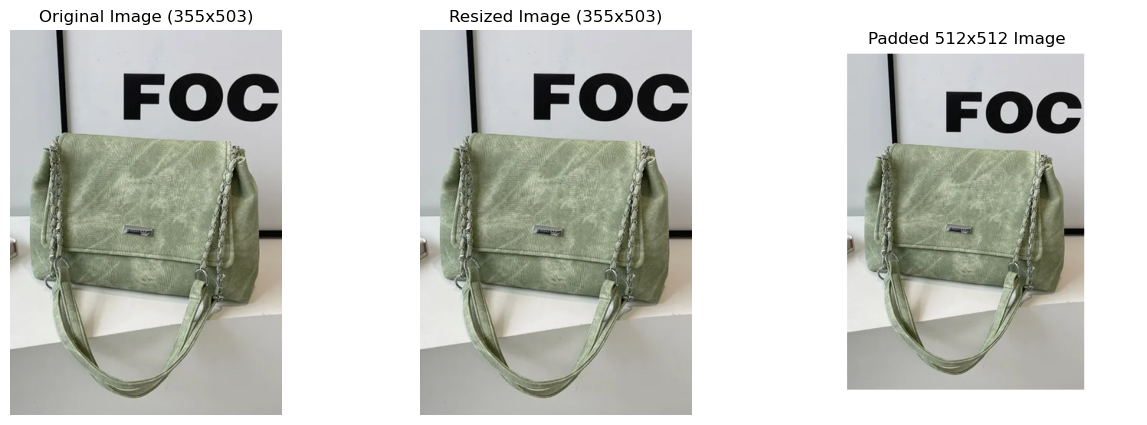

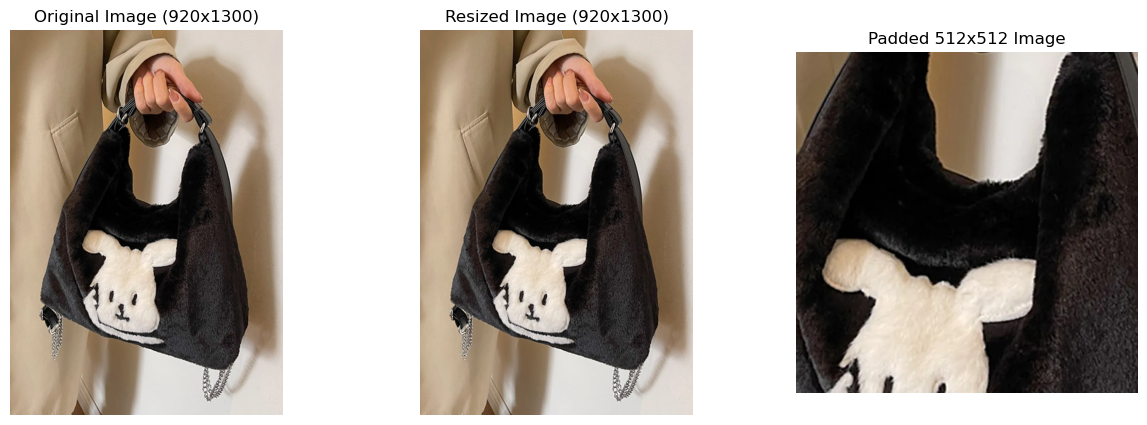

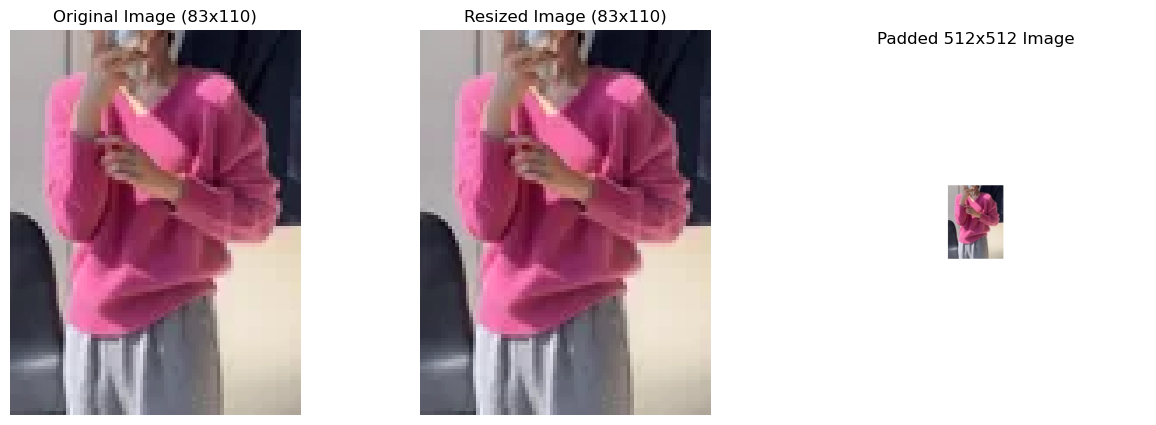

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import aiohttp
import asyncio
from io import BytesIO
from tqdm.asyncio import tqdm as async_tqdm
import random

def resize_image_for_phash(img, resolution):
    width, height = map(int, resolution.split('x'))
    resized_img = img.resize((width, height), Image.Resampling.LANCZOS)
    
    final_img = Image.new('RGB', (512, 512), (255, 255, 255))
    
    paste_pos = ((512 - width) // 2, (512 - height) // 2)
    final_img.paste(resized_img, paste_pos)
    
    return resized_img, final_img

def display_image_resizing(original_img, resized_img, final_img, original_resolution, new_resolution):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original Image ({original_resolution})')
    axes[0].axis('off')
    
    axes[1].imshow(resized_img)
    axes[1].set_title(f'Resized Image ({new_resolution})')
    axes[1].axis('off')
    
    axes[2].imshow(final_img)
    axes[2].set_title('Padded 512x512 Image')
    axes[2].axis('off')
    
    plt.show()
    
df = pd.read_csv('image_data.csv')
df = df.dropna(subset=['small_image'])

sample_size = 6
sample_df = df.sample(n=sample_size, random_state=42)

resolutions = ["707x1000", "500x500", "128x128", "355x503", "920x1300", "83x110"]

base_url = "https://d1it09c4puycyh.cloudfront.net"

async def fetch_image(session, url):
    async with session.get(url) as response:
        if response.status == 200:
            img_data = await response.read()
            return Image.open(BytesIO(img_data)).convert('RGB')
        else:
            raise IOError(f"Failed to fetch image from {url}, status code: {response.status}")

async def process_images():
    async with aiohttp.ClientSession() as session:
        tasks = []
        for idx, (_, row) in enumerate(sample_df.iterrows()):
            resolution = resolutions[idx % len(resolutions)]  # Assign a unique resolution to each image
            image_url = f"{base_url}/{resolution}/catalog/product{row['small_image'].strip()}"
            tasks.append(fetch_image(session, image_url))
        images = await async_tqdm.gather(*tasks)
    return images

images = await process_images()

for idx, img in enumerate(images):
    original_resolution = f"{img.size[0]}x{img.size[1]}"
    new_resolution = resolutions[idx % len(resolutions)]  #assigning a different resolution to each image
    resized_img, final_img = resize_image_for_phash(img, new_resolution)
    display_image_resizing(img, resized_img, final_img, original_resolution, new_resolution)
